# Entrenar Detectron 2 con imágenes de botellas

Primero conectamos nuestro notebook a drive para poder obtener todos los datos de una manera mucho más sencilla.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalación de las librerías necesarias.

In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install LossEvalHook
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 26.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=77005d0f4749f16fae2d2e377cb45bf714929faec2c70ca867210b15db7db7a2
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/

Importamos las librerías a utilizar.

In [ ]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

En esta función se van a armar los diccionarios de datos que nuestro modelo va a ocupar para posteriormente realizar las predicciones de los cuadros delimitadores, así como la segmentación y el nombre de las clases que se utilizan.

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 540
        record["width"] = 540
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

Colocamos el path de donde se encuentran nuestros datos de entrenamineto y test.

In [ ]:
data_path = '/content/drive/MyDrive/Detectron2/Data/'

Registramos nuestro catalogo de clases custom, para poder utilizarlo en el modelo.

In [ ]:
classes = ['Lata', 'Botella']

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

Importamos los componentes del modelo, así como los de visualización.

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

Definimos nuestros archivos de configuración inicial para el modelo, el número de worker, items per batch, así como el número base de resolución, las epocas sobre las que iterara el modelo y el número de clases que estamos manejando.

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ("category_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

Aqui unicamente establecemos el directorio donde se encontrará nuestro modelo, así como el tipo de entranamiento que utilizaremos, si este seguira con algun entrenamiento previo o no.

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/04 21:35:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/04 21:35:38 d2.engine.train_loop]: Starting training from iteration 0
[12/04 21:35:47 d2.utils.events]:  eta: 0:07:07  iter: 19  total_loss: 1.974  loss_cls: 1.084  loss_box_reg: 0.1818  loss_mask: 0.6946  loss_rpn_cls: 0.0009451  loss_rpn_loc: 0.004103  time: 0.4248  data_time: 0.0333  lr: 4.9953e-06  max_mem: 2837M
[12/04 21:35:55 d2.utils.events]:  eta: 0:06:47  iter: 39  total_loss: 1.865  loss_cls: 0.9682  loss_box_reg: 0.1852  loss_mask: 0.6771  loss_rpn_cls: 0.005106  loss_rpn_loc: 0.006412  time: 0.4215  data_time: 0.0099  lr: 9.9902e-06  max_mem: 3062M
[12/04 21:36:03 d2.utils.events]:  eta: 0:06:33  iter: 59  total_loss: 1.572  loss_cls: 0.7463  loss_box_reg: 0.1766  loss_mask: 0.6373  loss_rpn_cls: 0.005321  loss_rpn_loc: 0.003087  time: 0.4161  data_time: 0.0075  lr: 1.4985e-05  max_mem: 3062M
[12/04 21:36:12 d2.utils.events]:  eta: 0:06:22  iter: 79  total_loss: 1.217  loss_cls: 0.4641  loss_box_reg: 0.1744  loss_mask: 0.5806  loss_rpn_cls: 0.0008095  loss_rpn_loc: 0.0

Se definen los pesos que utilizará nuestro modelo, en este caso el del directorio que creamos en el paso anterior.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final_Makima.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.70
cfg.DATASETS.TEST = ("vision_test", )
predictor = DefaultPredictor(cfg)

Definimos el path de la imagen que queremos predecir.

In [ ]:
imagenleer= '/content/drive/MyDrive/Detectron2/imagenesPred/2.jpeg'

Aquí unicamente lo que hacemos es realizar la predicción de la imagen, así como la visualización con matplotlib de la misma.

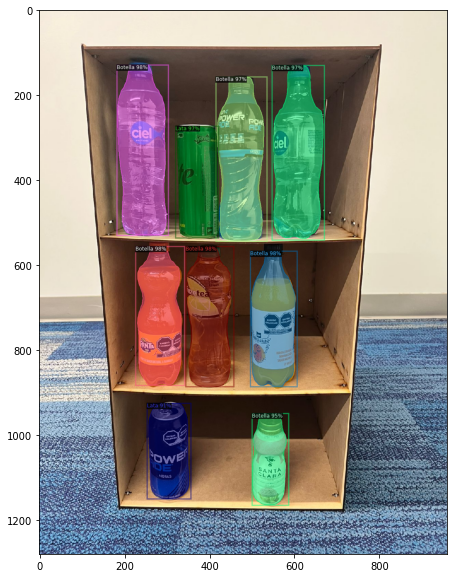

In [ ]:
import matplotlib.pyplot as plt
img = cv2.imread(imagenleer)
plt.figure(figsize=(14,10))
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
                metadata=microcontroller_metadata, 
                scale=0.8, 
                #instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

### Recorte de objetos reconocidos

En esta función lo que se realiza es recortar los objetos reconocidos por el modelo, se toma en cuenta los cuadrantes de la bounding box, teniendo esas coordenaadas con PIL e image.crop podemos pasarle los puntos en los que queremos recortar las imagenes.

In [ ]:
import PIL
import operator

def crop_object(image, box, name):
  """Crops an object in an image

  Inputs:
    image: PIL image
    box: one box from Detectron2 pred_boxes
  """
  x_top_left = box[0]
  y_top_left = box[1]
  x_bottom_right = box[2]
  y_bottom_right = box[3]

  crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))
  crop_img.save(name)
  plt.figure(figsize=(14,10))
  plt.imshow(crop_img)

### Objetos no reconocidos

Esto principalmente se hace para los objetos no reconocidos, aunque de cierta forma tambien le asigna un cierto orden al código y el recorte de objetos.

Las bounding boxes se organizan por el tamaño de su "Y" inferior, es decir en este caso, donde esta el fondo de cada botella o lata reconocido, con la finalidad de organizarlas por filas del refri, permitiendo así saber cuantas botellas hay en una fila dependiendo de su altura.

In [ ]:
def organize_boxes(listaBoxes):
  contador = 0
  lista = []
  listaBoxes = sorted(listaBoxes, key = lambda x: x[3])
  while contador < len(listaBoxes):
    if contador > 0:
      temp = sorted(temp, key = lambda x: x[2])
      lista.append(temp)
    temp = []
    valorY = listaBoxes[contador][3]
    for i in range(contador,len(listaBoxes)):
      if listaBoxes[i][3]-valorY <100 and listaBoxes[i][3]-valorY >-100:
        temp.append(listaBoxes[i])
        contador +=1
      else:
        break
  temp = sorted(temp, key = lambda x: x[2])
  lista.append(temp)
  return lista

Esta es una de las partes más extensas de código, primero se obtiene la medida de una botella en su eje "X" así como en su eje "Y" lo que nos permite saber en cualquier tamaño de imagen cuanto mide una botella tanto de alto como de ancho.

Posteriormente se recorren todas las listas de boxes que basicamente contiene matrices en donde cada matriz es una fila y cada una de sus filas son las 4 coordenadas de cada una de las botellas o latas de cada fila.

Tambien necesitamos otro ordenamiento con la finalidad de encontrar filas intermedias que literalmente no contengan ningún producto es por ello que hacemos dos listas extra que contienen cada fila ordenadas de formas diferentes, para los fondos de las botellas los ordenamos de forma descendente ya que entre más abajo este el fondo su número es mayor, mientras que para la parte de arriba de las botellas queremos ordenarlas de forma ascendente, ya que entre más alta sea la botella su número será menor, esto porque la parte más alta de la imagen es el 0 mientras que la parte más baja de la imagen representa su tamaño total.

En cambio, para la primera fila es un poco más sencillo si la altura de las tapas de las botellas de la primera fila menos el tamaño de una botella en su eje "Y" es mayor a 0 significa que podría camber otra botella arriba, por lo tanto, hay una fila vacia arriba de las primera botellas detectadas por el modelo.

Para la última fila aplica algo muy parecido si la suma del fondo las ultimas botellas detectadas se le suma el tamaño de una botella en su eje "Y" es menor que el tamaño de la imagen, significa que entonces podría caber una botella debajo de las ultimas detectadas por el modelo.


Para los espacios intermedios entre las filas, lo que se tiene que hacer es revisar entre las botellas detectadas en las filas, si entre cada bounding box su resta es mayor a la medida de una botella en el eje "X" significa que podría caber una botella en ese intermedio.

In [ ]:
def crop_No_Recognized(listaBoxes,image):
  shapeBox= listaBoxes[0][0][2] - listaBoxes[0][0][0]
  shapeBoxY= listaBoxes[0][0][3] - listaBoxes[0][0][1]
  print("Tamaño de la box X inicial: ",shapeBox)
  print("Tamaño de la box Y inicial: ",shapeBoxY)
  contador = 0
  filas = 0
  ultima_fila = []
  fila_anterior = listaBoxes[0][0][1]
  for RangeBoxes in listaBoxes:
    RangeBoxesYBot = sorted(RangeBoxes, key = lambda x: x[1],reverse=True)
    RangeBoxesYTop = sorted(RangeBoxes, key = lambda x: x[3])
    print("Box Range Ordenado Y Bot: ", RangeBoxesYBot)
    print("Box Range Ordenado Y Top: ", RangeBoxesYTop)
    ultima_fila = RangeBoxes
    print("Box Y BOT: ", RangeBoxesYBot[0][1])
    print("Box Y TOP: ", fila_anterior+150)
    if (RangeBoxesYBot[0][1]-fila_anterior)>shapeBoxY:
      newbox = [0, fila_anterior+150, image.size[0], RangeBoxesYBot[0][1]]
      name = "Medio"+ str(contador) + "_predict.jpg"
      #print(newbox,name)
      crop_img = crop_object(image, newbox, name)
      contador +=1
    if RangeBoxes[0][0]-shapeBox>0:
      newbox = [0, RangeBoxes[0][1], RangeBoxes[0][0], RangeBoxes[0][3]]
      name = "NotRecognized"+ str(contador) + "_predict.jpg"
      #print(newbox,name)
      crop_img = crop_object(image, newbox, name)
      contador +=1
    if image.size[0]-RangeBoxes[-1][2]>shapeBox:
      newbox = [RangeBoxes[-1][2], RangeBoxes[-1][1], image.size[0], RangeBoxes[-1][3]]
      name = "NotRecognized"+ str(contador) + "_predict.jpg"
      #print(newbox,name)
      crop_img = crop_object(image, newbox, name)
      contador +=1
    if filas == 0:
      if RangeBoxes[0][1]-shapeBoxY>0:
        print("Se cumplio la regla Arriba vacia")
        newbox = [0, 0, image.size[0], RangeBoxes[0][1]]
        name = "filaArribaVacia"+ str(contador) + "_predict.jpg"
        #print(newbox,name)
        crop_img = crop_object(image, newbox, name)
        contador +=1
    for boxNum in range(len(RangeBoxes)-1):
      if range(len(RangeBoxes)-1):
        ultima_filaY = RangeBoxes[boxNum+1][3]
      elif (RangeBoxes[boxNum+1][0] - RangeBoxes[boxNum][2]) > shapeBox:
        newbox = [RangeBoxes[boxNum][2], RangeBoxes[boxNum][1], RangeBoxes[boxNum+1][0], RangeBoxes[boxNum][3]]
        name = "NotRecognized"+ str(contador) + "_predict.jpg"
        crop_img = crop_object(image, newbox, name)
        contador +=1
    filas +=1
    fila_anterior = RangeBoxesYTop[0][3]-150
  if ultima_fila[0][3]+shapeBoxY<image.size[1]:
        print("Se cumplio la regla")
        newbox = [0, ultima_fila[0][3], image.size[0], image.size[1]]
        name = "filaArribaVacia"+ str(contador) + "_predict.jpg"
        #print(newbox,name)
        crop_img = crop_object(image, newbox, name)
        contador +=1

Por último, aqui mandamos a llamar a todas las funciones que definimos anteriormente, con las boxes que se obtuvieron de nuestro modelo.

Tamaño de la box X inicial:  152.09784
Tamaño de la box Y inicial:  501.11542
Box Range Ordenado Y Bot:  [array([401.77817, 340.7655 , 528.1083 , 669.6375 ], dtype=float32), array([520.0014 , 196.08257, 670.3306 , 679.6102 ], dtype=float32), array([685.60693, 162.70795, 838.59106, 676.78217], dtype=float32), array([228.4657 , 161.33325, 380.56354, 662.44867], dtype=float32)]
Box Range Ordenado Y Top:  [array([228.4657 , 161.33325, 380.56354, 662.44867], dtype=float32), array([401.77817, 340.7655 , 528.1083 , 669.6375 ], dtype=float32), array([685.60693, 162.70795, 838.59106, 676.78217], dtype=float32), array([520.0014 , 196.08257, 670.3306 , 679.6102 ], dtype=float32)]
Box Y BOT:  340.7655
Box Y TOP:  311.333251953125
Box Range Ordenado Y Bot:  [array([ 621.6836,  708.8886,  758.2333, 1107.3585], dtype=float32), array([ 283.2062,  695.1936,  428.0406, 1104.0952], dtype=float32), array([ 431.54523,  695.04004,  572.76074, 1107.7168 ], dtype=float32)]
Box Range Ordenado Y Top:  [array([ 

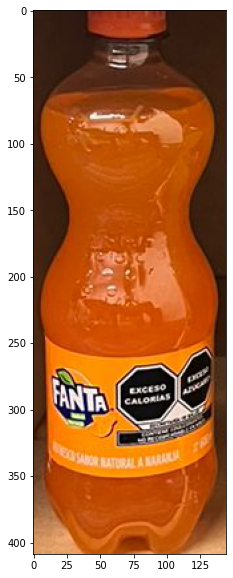

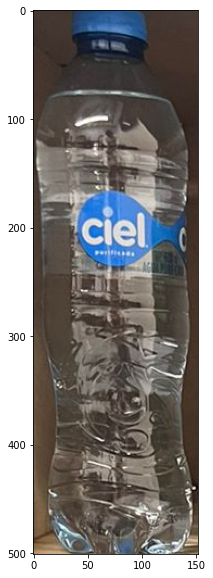

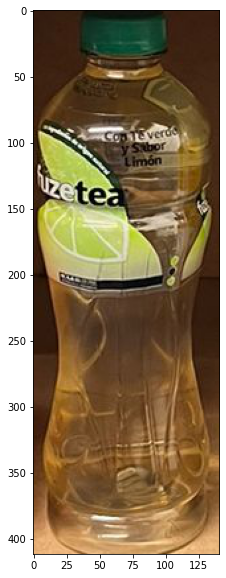

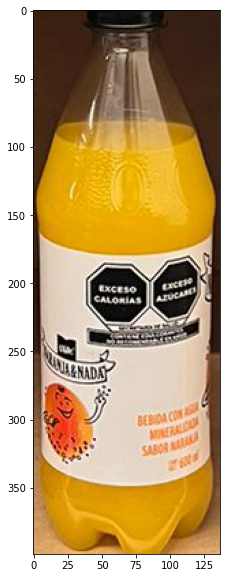

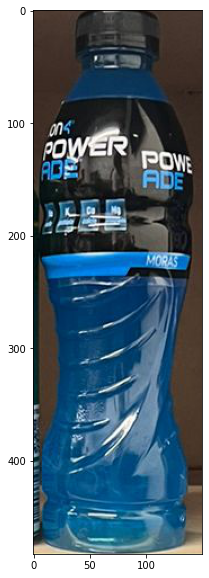

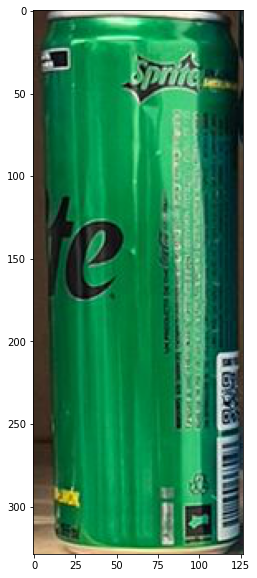

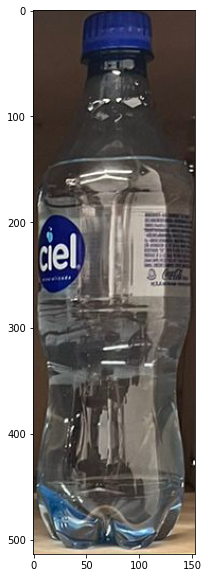

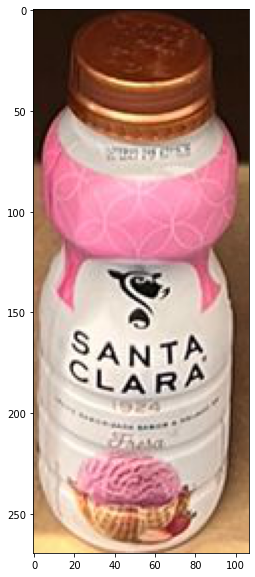

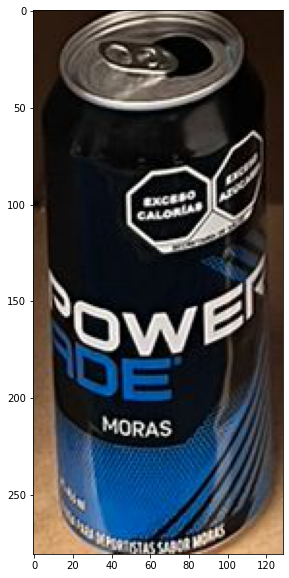

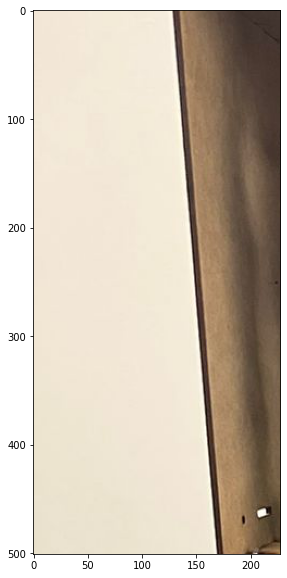

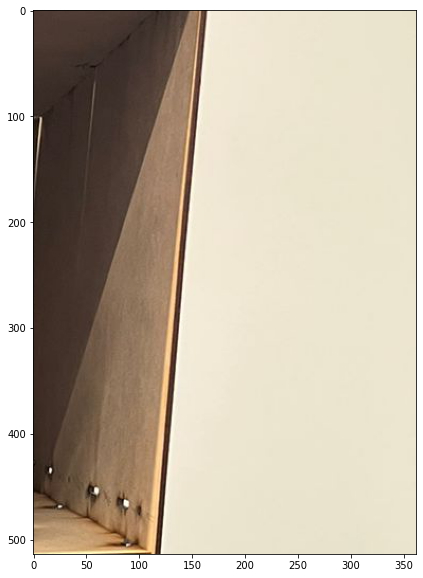

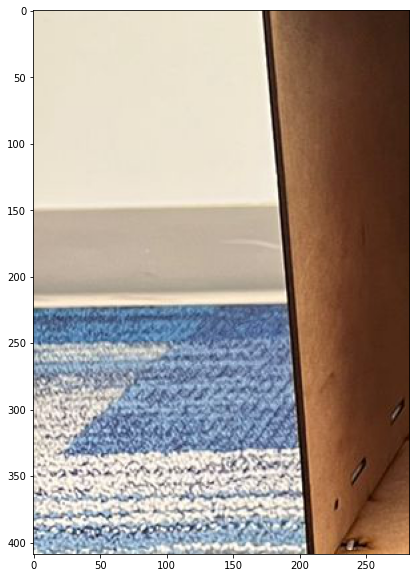

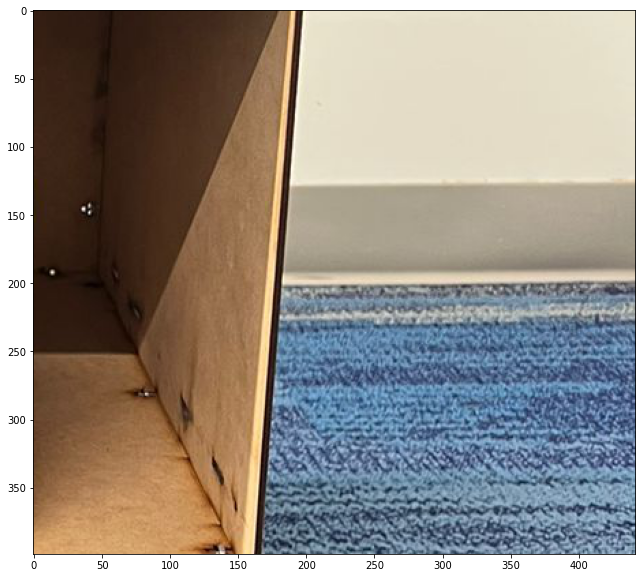

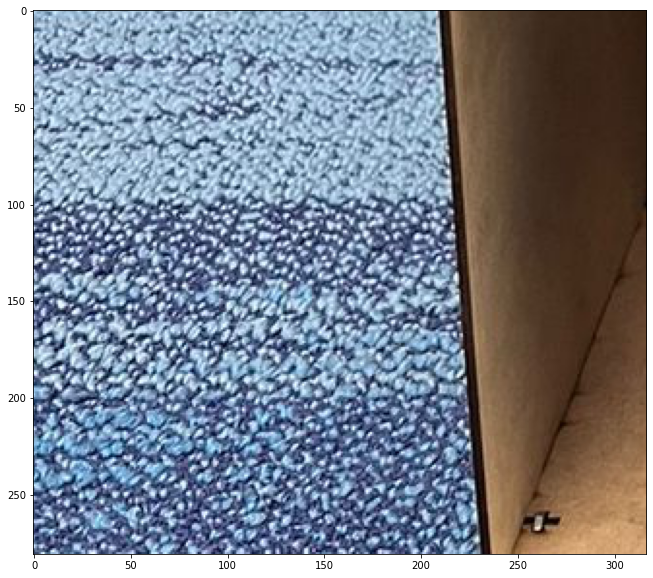

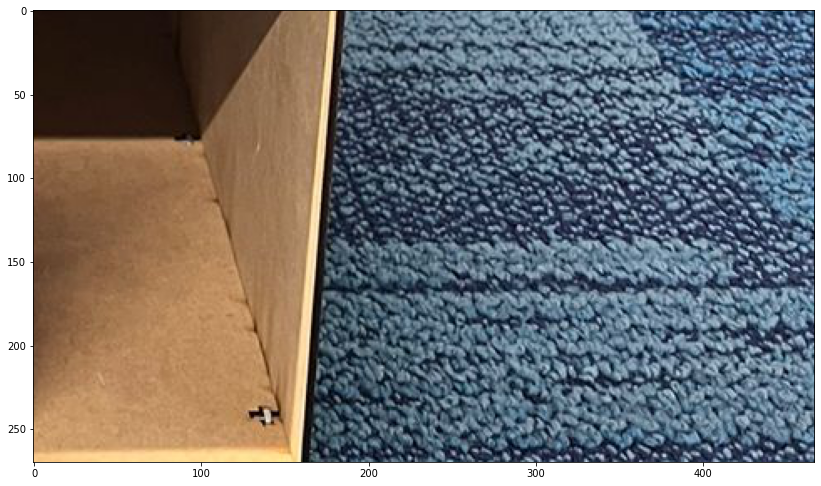

In [ ]:
# Get pred_boxes from Detectron2 prediction outputs
boxes = outputs["instances"].pred_boxes
# Select 1 box:
image = PIL.Image.open(imagenleer).convert('RGB') 
boxes = list(boxes)
listaBoxes = []
for i in range(len(boxes)):
  name = str(i) + "predict.jpg"
  box = boxes[i].detach().cpu().numpy()
  listaBoxes.append(box)
  # Crop the PIL image using predicted box coordinates
  crop_img = crop_object(image, box, name)
listaBoxes = organize_boxes(listaBoxes)
crop_No_Recognized(listaBoxes,image)